In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM
import warnings
from urllib.request import urlretrieve

In [2]:
url = "https://raw.githubusercontent.com/Arshiaafl/Food-Forecasting/main/train.csv" #This dataset is in my Github repo, and it's publicly available for download. You just need to run this code.
filename = "Food.csv"

urlretrieve(url, filename)

df = pd.read_csv(filename)

# Display the first few rows of the DataFrame
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [3]:
df.shape

(456548, 9)

In [4]:
df.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


In [5]:
df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders'],
      dtype='object')

In [6]:
df.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
dtype: object

In [7]:
df.isnull().sum().sort_values(ascending=False)

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [8]:
df.duplicated().any()

False

In [9]:
df.dropna(axis=0, inplace=True)

In [10]:
features = df[['week','center_id','meal_id','num_orders']]
top_20_orders = features.nlargest(20, 'num_orders')
print('Top 20')
print(top_20_orders[['week','center_id','meal_id','num_orders']])

Top 20
        week  center_id  meal_id  num_orders
14050      5         43     2290       24299
19700      7         43     2290       15336
16904      6         43     2290       14229
13923      5         10     2290       13580
413351   132         43     1971       13150
12068      5         89     2290       12489
90857     32        146     1754       12327
12509      5        137     2290       12177
12300      5         99     2290       12137
85371     30        126     1754       11380
11649      5         11     2290       11260
13286      5        104     2290       11246
211492    70         43     1754       11110
411625   132        137     1971       11056
11770      5         13     2290       10745
252561    83        104     1727       10544
14395      5         51     2290       10449
11853      5         52     2290       10435
12260      5        108     2290       10259
109331    38         99     2290       10193


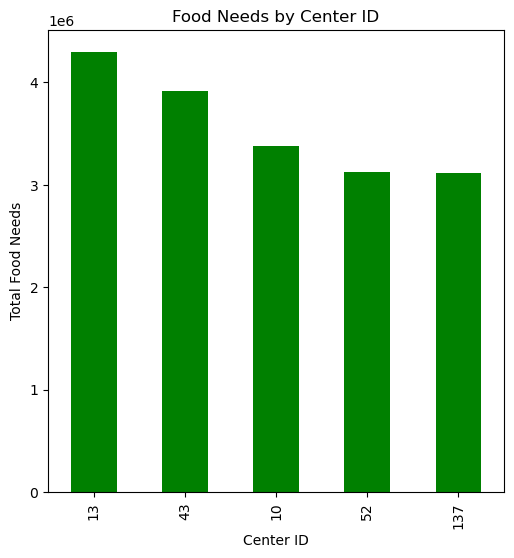

In [11]:
food_needs = df.groupby('center_id')['num_orders'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.subplot(1,3,1)
food_needs.plot(kind='bar',color='green')
plt.title('Food Needs by Center ID')
plt.xlabel('Center ID')
plt.ylabel('Total Food Needs')
plt.show()

In [12]:
df = df.sort_values(by='week')

In [13]:
X = df['num_orders'].values.reshape(-1,1)
def create_sequences(data, sequence_length=8, step_size=1):
    sequences = []
    targets = []

    for i in range(0, len(data) - sequence_length, step_size):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length:i+sequence_length+1]  

        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [14]:
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)
X_transform

array([[-0.21436718],
       [-0.45936471],
       [-0.45431321],
       ...,
       [-0.55534312],
       [-0.35580905],
       [-0.25225339]])

In [15]:
X, y = create_sequences(X_transform)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [17]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
rf_model = RandomForestRegressor(max_depth=10, min_samples_leaf=4)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4)

In [18]:
y_pred = rf_model.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 5: Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.7396781109112327


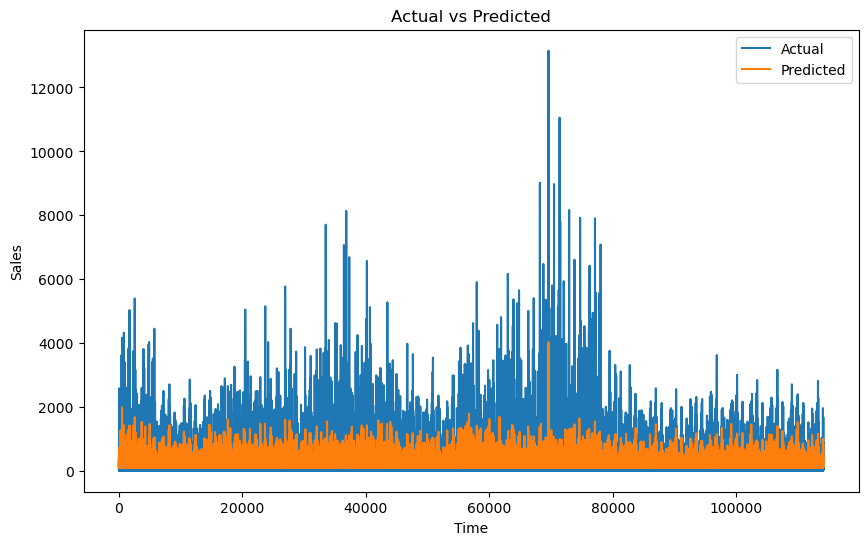

Root Mean Squared (RMS) Error: 340.5112128327016


In [19]:
# Reshape to 2D
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Inverse transform to get the original scale
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate RMS error
rms_error = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"Root Mean Squared (RMS) Error: {rms_error}")